In [249]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

In [259]:
from sklearn.datasets import fetch_california_housing

df = pd.read_csv("XAI/diabetes.csv")
df


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [261]:

X = df.drop('Outcome',axis=1)
y = df['Outcome']

In [263]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

[]

<Figure size 3000x3000 with 0 Axes>

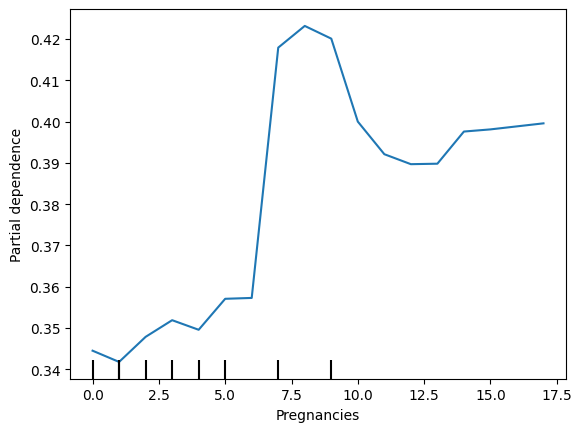

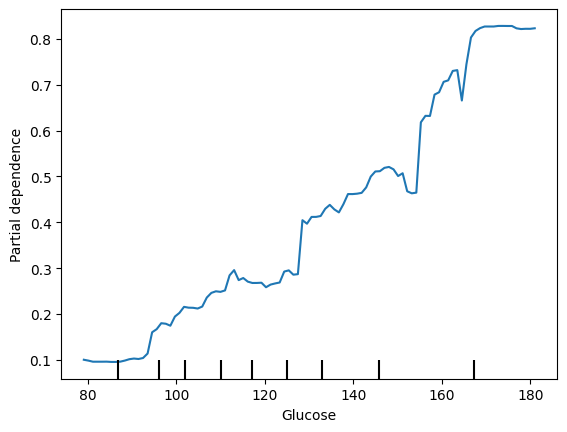

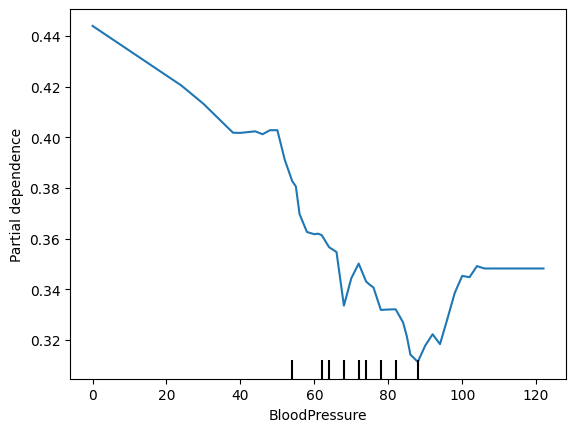

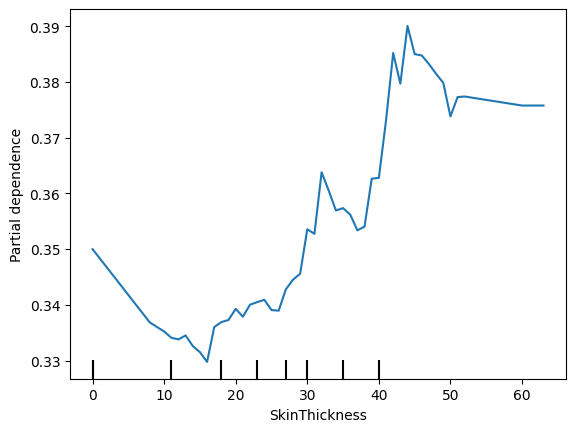

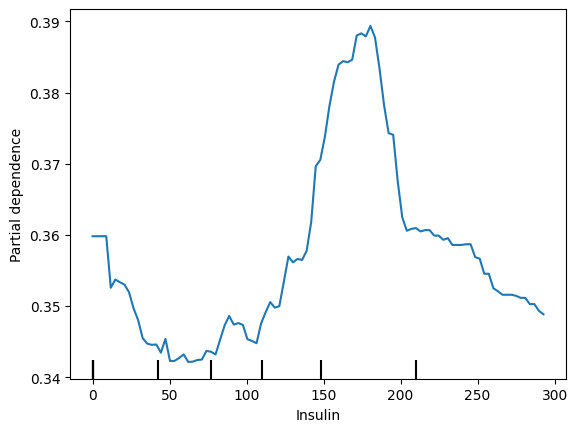

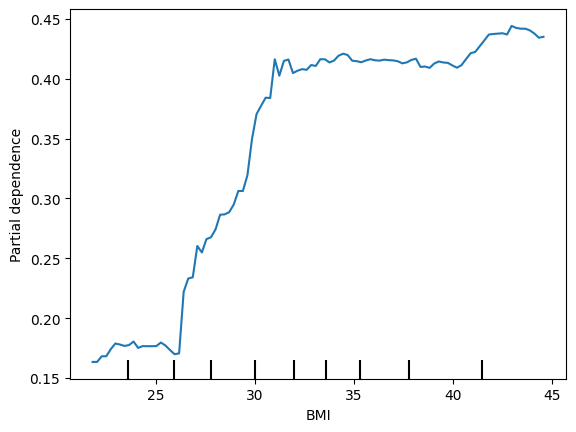

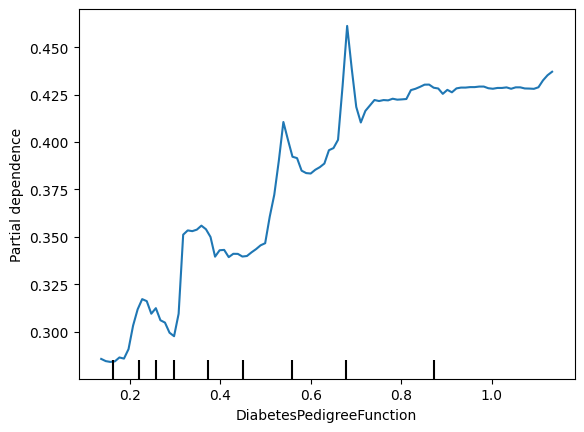

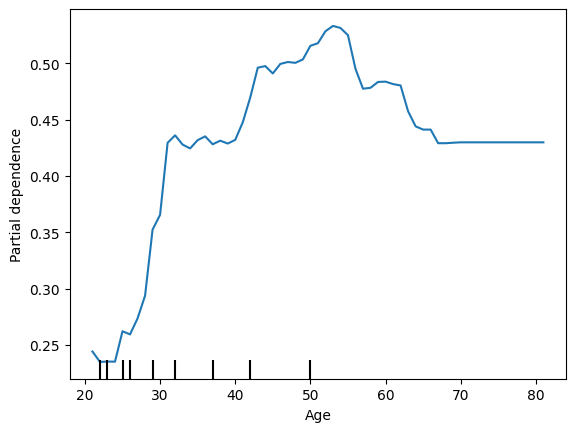

In [265]:
plt.figure(figsize=(30,30))
for col in X_train.columns:
  PartialDependenceDisplay.from_estimator(model,X_train,[col])
plt.plot()

[]

<Figure size 3000x3000 with 0 Axes>

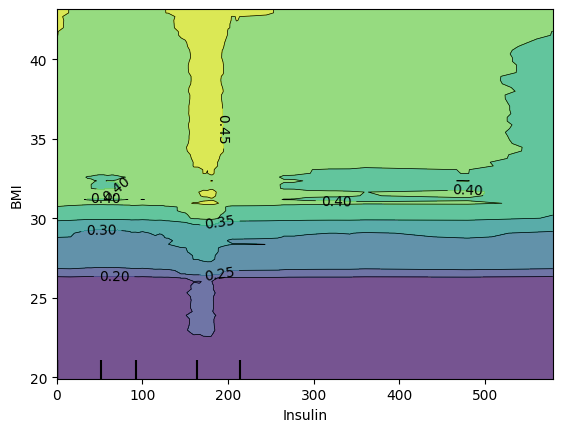

In [269]:
plt.figure(figsize=(30,30))
PartialDependenceDisplay.from_estimator(model,X_test,[('Insulin','BMI')])
plt.plot()

Grad CAM

In [71]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [73]:
# Import tf-keras-vis (make sure it's installed via pip install tf-keras-vis)
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

In [189]:
# Load and preprocess the image
img_path = r'M:\Images\WhatsApp Image 2025-02-18 at 13.24.36_5e6cf0e9.jpg'  # Use raw string for Windows path
img = Image.open(img_path).convert('L')  # Convert to grayscale
img = img.resize((28, 28))  # Resize to match model input
image_array = np.array(img).astype('float32') / 255.0
image_array = np.expand_dims(image_array, axis=(0, -1))
# Dummy label (since we are not training)
label = 0

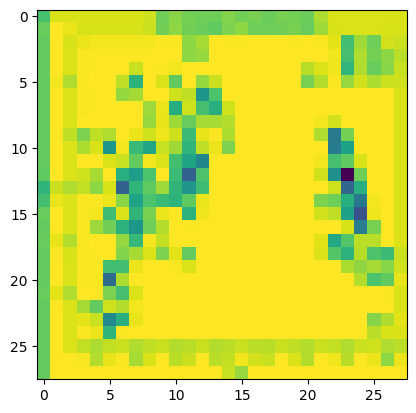

In [191]:
plt.imshow(img)

In [193]:
# Build the model using Functional API (required for tf-keras-vis)
inputs = Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

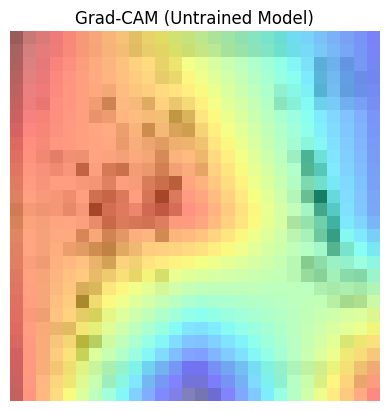

In [195]:
# Grad-CAM setup
gradcam = Gradcam(model, model_modifier=ReplaceToLinear())
score = CategoricalScore([label])
cam = gradcam(score, image_array)  # Compute heatmap
heatmap = cam[0]

# Plot the Grad-CAM result
plt.imshow(image_array[0].squeeze(), cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM (Untrained Model)")
plt.axis('off')
plt.show()

LRP

In [198]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [206]:
# === 1. Load and preprocess the image ===
img_path = r"M:\Images\WhatsApp Image 2025-02-18 at 13.24.36_5e6cf0e9.jpg"  # Your local path
img = Image.open(img_path).convert('L')  # Grayscale
img = img.resize((28, 28))
img_array = np.array(img).astype('float32') / 255.0
img_array = np.expand_dims(img_array, axis=-1)  # shape: (28, 28, 1)
img_batch = np.expand_dims(img_array, axis=0)   # shape: (1, 28, 28, 1)

In [208]:
# === 2. Build a simple CNN model (untrained) ===
inputs = Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

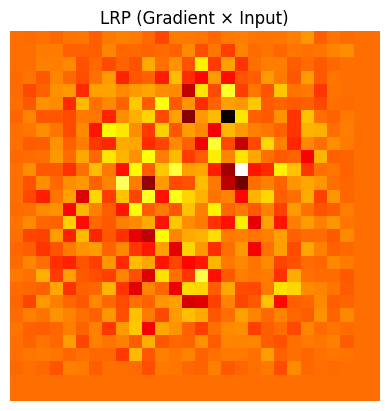

In [210]:
# === 3. LRP using Gradient × Input ===
img_tensor = tf.convert_to_tensor(img_batch)

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    preds = model(img_tensor)
    class_idx = tf.argmax(preds[0])
    loss = preds[0, class_idx]

# Compute gradients
grads = tape.gradient(loss, img_tensor)[0].numpy()  # shape: (28, 28, 1)
relevance = grads * img_array  # Element-wise multiplication

# === 4. Plot the relevance heatmap ===
plt.imshow(relevance.squeeze(), cmap='hot')
plt.title("LRP (Gradient × Input)")
plt.axis('off')
plt.show()

Surrogate Model

In [213]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [219]:
df=pd.read_csv('XAI/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [223]:
rf_model=RandomForestClassifier()
X=df.drop('Outcome',axis=1)
y=df['Outcome']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
rf_model.fit(X_train,y_train)
y_pred=rf_model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.7207792207792207


In [225]:
dt_model=DecisionTreeClassifier()
dt_model.fit(X_test,y_pred)

DecisionTreeClassifier()

[Text(0.5555555555555556, 0.9375, 'Glucose <= 142.5\ngini = 0.463\nsamples = 154\nvalue = [98, 56]\nclass = Diabetes'),
 Text(0.3333333333333333, 0.8125, 'Age <= 35.5\ngini = 0.259\nsamples = 111\nvalue = [94, 17]\nclass = Diabetes'),
 Text(0.4444444444444444, 0.875, 'True  '),
 Text(0.2222222222222222, 0.6875, 'BloodPressure <= 93.0\ngini = 0.079\nsamples = 73\nvalue = [70, 3]\nclass = Diabetes'),
 Text(0.16666666666666666, 0.5625, 'BloodPressure <= 24.0\ngini = 0.054\nsamples = 72\nvalue = [70, 2]\nclass = Diabetes'),
 Text(0.1111111111111111, 0.4375, 'BMI <= 17.65\ngini = 0.444\nsamples = 6\nvalue = [4, 2]\nclass = Diabetes'),
 Text(0.05555555555555555, 0.3125, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = Diabetes'),
 Text(0.16666666666666666, 0.3125, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = No Diabetes'),
 Text(0.2222222222222222, 0.4375, 'gini = 0.0\nsamples = 66\nvalue = [66, 0]\nclass = Diabetes'),
 Text(0.2777777777777778, 0.5625, 'gini = 0.0\nsamples = 1\nvalue =

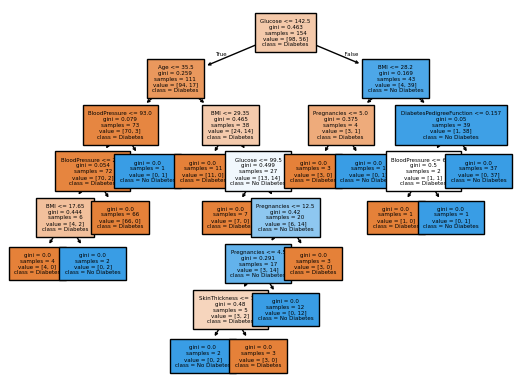

In [227]:
plot_tree(dt_model,
feature_names=X.columns,
class_names=['Diabetes','No Diabetes'],
filled=True,
fontsize=4
)


Sensitivity Analysis & Feature Importance

In [230]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [277]:
df = pd.read_csv("XAI/diabetes.csv")
df

# Use only 2 classes for simplicity
# Split data
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = RandomForestClassifier().fit(X_train, y_train)


<BarContainer object of 8 artists>

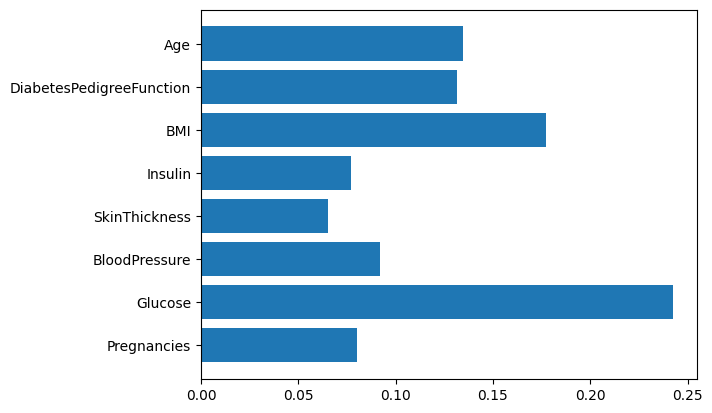

In [279]:
feat_imp=model.feature_importances_
feat=X.columns
plt.barh(feat,feat_imp)
